Device set to cuda.
Seeds set to 1129142087.
Loading model...


c:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Done.
Epoch 1/5
----------


train: 100%|██████████| 45/45 [00:29<00:00,  1.52it/s]


train Loss: 0.410 Acc: 82.6977%


test: 100%|██████████| 19/19 [00:09<00:00,  1.90it/s]


test Loss: 0.571 Acc: 76.0469%

Epoch 2/5
----------


train: 100%|██████████| 45/45 [00:27<00:00,  1.62it/s]


train Loss: 0.380 Acc: 86.1582%


test: 100%|██████████| 19/19 [00:10<00:00,  1.89it/s]


test Loss: 0.417 Acc: 85.0921%

Epoch 3/5
----------


train: 100%|██████████| 45/45 [00:28<00:00,  1.60it/s]


train Loss: 0.381 Acc: 85.8051%


test: 100%|██████████| 19/19 [00:09<00:00,  1.93it/s]


test Loss: 0.425 Acc: 84.5896%

Epoch 4/5
----------


train: 100%|██████████| 45/45 [00:27<00:00,  1.64it/s]


train Loss: 0.380 Acc: 86.0876%


test: 100%|██████████| 19/19 [00:09<00:00,  1.91it/s]


test Loss: 0.432 Acc: 82.5796%

Epoch 5/5
----------


train: 100%|██████████| 45/45 [00:27<00:00,  1.61it/s]


train Loss: 0.382 Acc: 84.7458%


test: 100%|██████████| 19/19 [00:09<00:00,  1.95it/s]


test Loss: 0.441 Acc: 81.7420%

Training complete in 3m 12s
Best val Acc: 85.092127
----Done----
>> Model saved as:  model_1
>> Model saved in:  ./../models/


Evaluating the model...: 100%|██████████| 597/597 [00:14<00:00, 41.93it/s]


Accuracy: 85.09 %
              precision    recall  f1-score   support

           B       0.75      0.70      0.73       168
           M       0.89      0.91      0.90       429

    accuracy                           0.85       597
   macro avg       0.82      0.81      0.81       597
weighted avg       0.85      0.85      0.85       597

[[118  50]
 [ 39 390]]
Done.


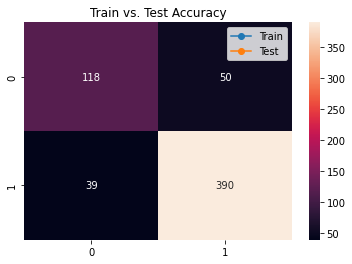

In [1]:
"""
Assigment 2, week 3 - Introduction to Focus Areas (Data Science)
author: @maxo
link: github.com/scaramir/ifa-2022
date: 2022-11-08
"""

#-----------Hyperparameters-----------
use_normalize = False
pic_folder_path = 'S:/studium/data_for_nns/mkfold/fold2'
learning_rate = 0.0005
batch_size = 32
num_epochs = 5
num_classes = 2
load_trained_model = False
pretrained = False
reset_classifier_with_custom_layers = True
train_network = True
evaluate_network = True
model_type = 'resnext50_32x4d'
#model_type = 'wide_resnet50_2'
model_type = 'resnet18'
#model_type = 'vgg16'
output_model_path = './../models/'
output_model_name = 'model_1'
#----------------------------------


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import time, random

from tqdm import tqdm
from mo_nn_helpers import get_mean_and_std
from mo_nn_helpers import *

def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
        print('-----WARNING-----\nCUDA not available. Using CPU instead.')
    print('Device set to {}.'.format(device))
    return device
device = get_device()

# set seeds for reproducibility
def set_seeds(device = 'cuda', seed = 1129142087):
    random.seed(seed)
    np.random.seed(seed+1)
    torch.random.manual_seed(seed)
    if device == 'cuda':
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
    print('Seeds set to {}.'.format(seed))
    return
set_seeds(device)

data_dir = pic_folder_path
# data_dir = 'C:/Users/.../Project 2/data'

if use_normalize: 
    friendly, condoms = get_mean_and_std(data_dir)

# Data augmentation and normalization for training
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=(-20, 20)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
}
if use_normalize:
    data_transforms["train"].transforms.append(transforms.Normalize(mean=friendly, std=condoms, inplace=True))
    data_transforms["test"].transforms.append(transforms.Normalize(mean=friendly, std=condoms, inplace=True))


# ---------------Data Loader------------------
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                    for x in ["train", "test"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                    shuffle=True, num_workers=0)
                    for x in ["train", "test"]}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "test"]}
class_names = image_datasets["test"].classes
num_classes = len(class_names)
# --------------------------------------------


def get_model(model_type, load_trained_model, reset_classifier_with_custom_layers, num_classes=num_classes, pretrained=True, device='cuda', input_model_path=None, input_model_name=None):
    print('Loading model...')
    if (load_trained_model) & (input_model_path is not None) & (input_model_name is not None):
        model = load_model(input_model_path, input_model_name).to(device)
        print('Loaded model \'{}\'.'.format(input_model_name))
    else:
        # Load the pretrained model from pytorch
        if model_type == 'resnet18':
            model = models.resnet18(pretrained=pretrained)
        elif model_type == 'resnet50':
            model = models.resnet50(pretrained=pretrained)
        elif model_type == 'resnet101':
            model = models.resnet101(pretrained=pretrained)
        elif model_type == 'vgg16':
            model = models.vgg16(pretrained=pretrained)
        elif model_type == 'vgg16_bn':
            model = models.vgg16_bn(pretrained=pretrained)
        elif model_type == 'vgg19':
            model = models.vgg19(pretrained=pretrained)
        elif model_type == 'vgg19_bn':
            model = models.vgg19_bn(pretrained=pretrained)
        elif model_type == 'densenet121':
            model = models.densenet121(pretrained=pretrained)
        elif model_type == 'inception_v3':
            model = models.inception_v3(pretrained=pretrained)
        elif model_type == 'googlenet':
            model = models.googlenet(pretrained=pretrained)
        elif model_type == 'shufflenet_v2_x0_5':
            model = models.shufflenet_v2_x0_5(pretrained=pretrained)
        elif model_type == 'mobilenet_v2':
            model = models.mobilenet_v2(pretrained=pretrained)
        elif model_type == 'resnext50_32x4d':
            model = models.resnext50_32x4d(pretrained=pretrained)
        elif model_type == 'wide_resnet50_2':
            model = models.wide_resnet50_2(pretrained=pretrained)
        elif model_type == 'mnasnet0_75':
            model = models.mnasnet0_75(pretrained=pretrained)
        else:
            print('Model type not found.')
            return None

    if reset_classifier_with_custom_layers:
        # TODO: change access to in_features to replace classifier
        model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 256),
                                    nn.Dropout(p=0.4, inplace=True),
                                    nn.Linear(256, 100),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(100, num_classes))
    model = model.to(device)
    print("Done.")
    return model
model = get_model(model_type=model_type, load_trained_model=False, reset_classifier_with_custom_layers=reset_classifier_with_custom_layers, num_classes=num_classes, pretrained=pretrained, device=device, input_model_path=None, input_model_name=None)

criterion = nn.CrossEntropyLoss()
# SGD optimizer with momentum could lead faster to good results, but Adam is more stable
optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

if train_network:
    train_nn(model, dataloaders, dataset_sizes, criterion, optimizer, exp_lr_scheduler, output_model_path, output_model_name, num_epochs=num_epochs)


# TODO: Evaluation of 3 different networks. Use Sigmoid and max to get the probabilities for each of the binary classes.
def evaluate_model(model, dataset_sizes, criterion, class_names, image_datasets, device="cuda", dataset = "test"):
    # for every image of our test set, we will prdict the class and the probability
    # save the probabilities and the classes in a list
    # save the ground truth classes in a list
    # calculate the loss and the accuracy
    # plot the confusion matrix with the older heatmap function from project 1. 
    # plot the ROC curve with the function from project 1
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                    shuffle=False, num_workers=0)
                    for x in [dataset]}

    num_samples = 0
    num_correct = 0
    true_labels_list = []
    pred_labels_list = []
    pred_scores_list = []
    file_names_list = []
    model.eval()
    
    if device == "cuda":
        torch.cuda.empty_cache()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(dataloaders[dataset], desc="Evaluating the model...")):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #scores = torch.sigmoid(outputs)
            scores = torch.nn.Softmax(dim=1)(outputs)

            pred_scores, pred_labels = torch.max(scores, 1)

            num_correct += torch.sum(pred_labels == labels.data)
            num_samples += pred_labels.size(0)
            true_labels_list.append(class_names[labels.cpu().detach().numpy()[0]])
            pred_labels_list.append(class_names[pred_labels.cpu().detach().numpy()[0]])
            pred_scores_list.append(pred_scores.cpu().detach().numpy()[0])
            file_names_list.append(image_datasets[dataset].imgs[i][0].split("/")[-1])

    accuracy = 100 * float(num_correct) / num_samples
    #loss = criterion(outputs, labels)
    print("Accuracy: {:.2f} %".format(accuracy))
    #print("Loss: {:.2f}".format(loss))

    print(classification_report(true_labels_list, pred_labels_list))
    conf_mat = confusion_matrix(true_labels_list, pred_labels_list)
    print(conf_mat)

    # plot the confusion matrix
    sns.heatmap(conf_mat, annot=True, fmt='d')
    # plot roc curve
    #plot_roc_curve(model, true_labels_list, pred_labels_list) # type: ignore
    # Add the model name to the plot
    #plt.title(model_type)
    #plt.show()

    df = pd.DataFrame({
        "file_name": file_names_list,
        "true_label": true_labels_list,
        "pred_label": pred_labels_list,
        "pred_score": pred_scores_list})
    print("Done.")
    return df

if evaluate_network:
    df = evaluate_model(model, dataset_sizes, criterion, class_names, image_datasets, device="cuda", dataset = "test")

# TODO: Plot the results. (Also with a confusion matrix as heatmap?)

# TODO: report? 

Device set to cuda.
Seeds set to 1129142087.
Loading model...


c:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Done.
Epoch 1/5
----------


train: 100%|██████████| 45/45 [00:43<00:00,  1.03it/s]


train Loss: 0.650 Acc: 66.2429%


test: 100%|██████████| 19/19 [00:11<00:00,  1.62it/s]


test Loss: 0.608 Acc: 71.8593%

Epoch 2/5
----------


train: 100%|██████████| 45/45 [00:41<00:00,  1.08it/s]


train Loss: 0.641 Acc: 67.8672%


test: 100%|██████████| 19/19 [00:11<00:00,  1.62it/s]


test Loss: 0.591 Acc: 71.8593%

Epoch 3/5
----------


train: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


train Loss: 0.649 Acc: 67.8672%


test: 100%|██████████| 19/19 [00:11<00:00,  1.68it/s]


test Loss: 0.592 Acc: 71.8593%

Epoch 4/5
----------


train: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s]


train Loss: 0.643 Acc: 67.8672%


test: 100%|██████████| 19/19 [00:11<00:00,  1.69it/s]


test Loss: 0.592 Acc: 71.8593%

Epoch 5/5
----------


train: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s]


train Loss: 0.641 Acc: 67.8672%


test: 100%|██████████| 19/19 [00:11<00:00,  1.72it/s]


test Loss: 0.591 Acc: 71.8593%

Training complete in 4m 30s
Best val Acc: 71.859296
----Done----
>> Model saved as:  model_resnext
>> Model saved in:  ./../models/


Evaluating the model...: 100%|██████████| 597/597 [00:23<00:00, 25.47it/s]
c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 71.86 %
              precision    recall  f1-score   support

           B       0.00      0.00      0.00       168
           M       0.72      1.00      0.84       429

    accuracy                           0.72       597
   macro avg       0.36      0.50      0.42       597
weighted avg       0.52      0.72      0.60       597

[[  0 168]
 [  0 429]]
Done.


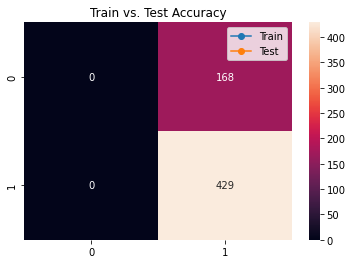

In [1]:
"""
Assigment 2, week 3 - Introduction to Focus Areas (Data Science)
author: @maxo
link: github.com/scaramir/ifa-2022
date: 2022-11-08
"""

#-----------Hyperparameters-----------
use_normalize = False
pic_folder_path = 'S:/studium/data_for_nns/mkfold/fold2'
learning_rate = 0.0005
learning_rate = 0.005
batch_size = 32
num_epochs = 5
num_classes = 2
load_trained_model = False
pretrained = False
reset_classifier_with_custom_layers = True
train_network = True
evaluate_network = True
model_type = 'resnext50_32x4d'
#model_type = 'wide_resnet50_2'
#model_type = 'resnet18'
#model_type = 'inception_v3'
output_model_path = './../models/'
output_model_name = 'model_resnext'
#----------------------------------


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import time, random

from tqdm import tqdm
from mo_nn_helpers import get_mean_and_std
from mo_nn_helpers import *

def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
        print('-----WARNING-----\nCUDA not available. Using CPU instead.')
    print('Device set to {}.'.format(device))
    return device
device = get_device()

# set seeds for reproducibility
def set_seeds(device = 'cuda', seed = 1129142087):
    random.seed(seed)
    np.random.seed(seed+1)
    torch.random.manual_seed(seed)
    if device == 'cuda':
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
    print('Seeds set to {}.'.format(seed))
    return
set_seeds(device)

data_dir = pic_folder_path
# data_dir = 'C:/Users/.../Project 2/data'

if use_normalize: 
    friendly, condoms = get_mean_and_std(data_dir)

# Data augmentation and normalization for training
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=(-20, 20)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
}
if use_normalize:
    data_transforms["train"].transforms.append(transforms.Normalize(mean=friendly, std=condoms, inplace=True))
    data_transforms["test"].transforms.append(transforms.Normalize(mean=friendly, std=condoms, inplace=True))


# ---------------Data Loader------------------
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                    for x in ["train", "test"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                    shuffle=True, num_workers=0)
                    for x in ["train", "test"]}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "test"]}
class_names = image_datasets["test"].classes
num_classes = len(class_names)
# --------------------------------------------


def get_model(model_type, load_trained_model, reset_classifier_with_custom_layers, num_classes=num_classes, pretrained=True, device='cuda', input_model_path=None, input_model_name=None):
    print('Loading model...')
    if (load_trained_model) & (input_model_path is not None) & (input_model_name is not None):
        model = load_model(input_model_path, input_model_name).to(device)
        print('Loaded model \'{}\'.'.format(input_model_name))
    else:
        # Load the pretrained model from pytorch
        if model_type == 'resnet18':
            model = models.resnet18(pretrained=pretrained)
        elif model_type == 'resnet50':
            model = models.resnet50(pretrained=pretrained)
        elif model_type == 'resnet101':
            model = models.resnet101(pretrained=pretrained)
        elif model_type == 'vgg16':
            model = models.vgg16(pretrained=pretrained)
        elif model_type == 'vgg16_bn':
            model = models.vgg16_bn(pretrained=pretrained)
        elif model_type == 'vgg19':
            model = models.vgg19(pretrained=pretrained)
        elif model_type == 'vgg19_bn':
            model = models.vgg19_bn(pretrained=pretrained)
        elif model_type == 'densenet121':
            model = models.densenet121(pretrained=pretrained)
        elif model_type == 'inception_v3':
            model = models.inception_v3(pretrained=pretrained)
        elif model_type == 'googlenet':
            model = models.googlenet(pretrained=pretrained)
        elif model_type == 'shufflenet_v2_x0_5':
            model = models.shufflenet_v2_x0_5(pretrained=pretrained)
        elif model_type == 'mobilenet_v2':
            model = models.mobilenet_v2(pretrained=pretrained)
        elif model_type == 'resnext50_32x4d':
            model = models.resnext50_32x4d(pretrained=pretrained)
        elif model_type == 'wide_resnet50_2':
            model = models.wide_resnet50_2(pretrained=pretrained)
        elif model_type == 'mnasnet0_75':
            model = models.mnasnet0_75(pretrained=pretrained)
        else:
            print('Model type not found.')
            return None

    if reset_classifier_with_custom_layers:
        # TODO: change access to in_features to replace classifier
        model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 256),
                                    nn.Dropout(p=0.4, inplace=True),
                                    nn.Linear(256, 100),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(100, num_classes))
    model = model.to(device)
    print("Done.")
    return model
model = get_model(model_type=model_type, load_trained_model=False, reset_classifier_with_custom_layers=reset_classifier_with_custom_layers, num_classes=num_classes, pretrained=pretrained, device=device, input_model_path=None, input_model_name=None)

criterion = nn.CrossEntropyLoss()
# SGD optimizer with momentum could lead faster to good results, but Adam is more stable
#optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

if train_network:
    train_nn(model, dataloaders, dataset_sizes, criterion, optimizer, exp_lr_scheduler, output_model_path, output_model_name, num_epochs=num_epochs)


# TODO: Evaluation of 3 different networks. Use Sigmoid and max to get the probabilities for each of the binary classes.
def evaluate_model(model, dataset_sizes, criterion, class_names, image_datasets, device="cuda", dataset = "test"):
    # for every image of our test set, we will prdict the class and the probability
    # save the probabilities and the classes in a list
    # save the ground truth classes in a list
    # calculate the loss and the accuracy
    # plot the confusion matrix with the older heatmap function from project 1. 
    # plot the ROC curve with the function from project 1
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                    shuffle=False, num_workers=0)
                    for x in [dataset]}

    num_samples = 0
    num_correct = 0
    true_labels_list = []
    pred_labels_list = []
    pred_scores_list = []
    file_names_list = []
    model.eval()
    
    if device == "cuda":
        torch.cuda.empty_cache()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(dataloaders[dataset], desc="Evaluating the model...")):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #scores = torch.sigmoid(outputs)
            scores = torch.nn.Softmax(dim=1)(outputs)

            pred_scores, pred_labels = torch.max(scores, 1)

            num_correct += torch.sum(pred_labels == labels.data)
            num_samples += pred_labels.size(0)
            true_labels_list.append(class_names[labels.cpu().detach().numpy()[0]])
            pred_labels_list.append(class_names[pred_labels.cpu().detach().numpy()[0]])
            pred_scores_list.append(pred_scores.cpu().detach().numpy()[0])
            file_names_list.append(image_datasets[dataset].imgs[i][0].split("/")[-1])

    accuracy = 100 * float(num_correct) / num_samples
    #loss = criterion(outputs, labels)
    print("Accuracy: {:.2f} %".format(accuracy))
    #print("Loss: {:.2f}".format(loss))

    print(classification_report(true_labels_list, pred_labels_list))
    conf_mat = confusion_matrix(true_labels_list, pred_labels_list)
    print(conf_mat)

    # plot the confusion matrix
    sns.heatmap(conf_mat, annot=True, fmt='d')
    # plot roc curve
    #plot_roc_curve(model, true_labels_list, pred_labels_list) # type: ignore
    # Add the model name to the plot
    #plt.title(model_type)
    #plt.show()

    df = pd.DataFrame({
        "file_name": file_names_list,
        "true_label": true_labels_list,
        "pred_label": pred_labels_list,
        "pred_score": pred_scores_list})
    print("Done.")
    return df

if evaluate_network:
    df = evaluate_model(model, dataset_sizes, criterion, class_names, image_datasets, device="cuda", dataset = "test")

# TODO: Plot the results. (Also with a confusion matrix as heatmap?)

# TODO: report? 

Device set to cuda.
Seeds set to 1129142087.
Loading model...


c:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Done.
Epoch 1/5
----------


train: 100%|██████████| 45/45 [00:50<00:00,  1.12s/it]


train Loss: 0.639 Acc: 67.8672%


test: 100%|██████████| 19/19 [00:12<00:00,  1.57it/s]


test Loss: 0.600 Acc: 71.8593%

Epoch 2/5
----------


train: 100%|██████████| 45/45 [00:48<00:00,  1.09s/it]


train Loss: 0.636 Acc: 67.8672%


test: 100%|██████████| 19/19 [00:12<00:00,  1.56it/s]


test Loss: 0.596 Acc: 71.8593%

Epoch 3/5
----------


train: 100%|██████████| 45/45 [00:49<00:00,  1.10s/it]


train Loss: 0.637 Acc: 67.8672%


test: 100%|██████████| 19/19 [00:12<00:00,  1.56it/s]


test Loss: 0.596 Acc: 71.8593%

Epoch 4/5
----------


train: 100%|██████████| 45/45 [00:48<00:00,  1.09s/it]


train Loss: 0.630 Acc: 67.8672%


test: 100%|██████████| 19/19 [00:12<00:00,  1.55it/s]


test Loss: 0.595 Acc: 71.8593%

Epoch 5/5
----------


train: 100%|██████████| 45/45 [00:50<00:00,  1.12s/it]


train Loss: 0.633 Acc: 67.8672%


test: 100%|██████████| 19/19 [00:12<00:00,  1.56it/s]


test Loss: 0.596 Acc: 71.8593%

Training complete in 5m 11s
Best val Acc: 71.859296
----Done----
>> Model saved as:  model_wide_resnet
>> Model saved in:  ./../models/


Evaluating the model...: 100%|██████████| 597/597 [00:21<00:00, 28.17it/s]
c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 71.86 %
              precision    recall  f1-score   support

           B       0.00      0.00      0.00       168
           M       0.72      1.00      0.84       429

    accuracy                           0.72       597
   macro avg       0.36      0.50      0.42       597
weighted avg       0.52      0.72      0.60       597

[[  0 168]
 [  0 429]]
Done.


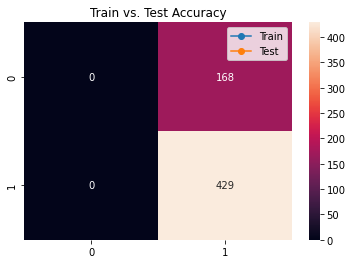

In [1]:
"""
Assigment 2, week 3 - Introduction to Focus Areas (Data Science)
author: @maxo
link: github.com/scaramir/ifa-2022
date: 2022-11-08
"""

#-----------Hyperparameters-----------
use_normalize = False
pic_folder_path = 'S:/studium/data_for_nns/mkfold/fold2'
learning_rate = 0.0005
learning_rate = 0.005
batch_size = 32
num_epochs = 5
num_classes = 2
load_trained_model = False
pretrained = False
reset_classifier_with_custom_layers = True
train_network = True
evaluate_network = True
#model_type = 'resnext50_32x4d'
#model_type = 'resnet18'
model_type = 'wide_resnet50_2'
output_model_path = './../models/'
output_model_name = 'model_wide_resnet'
#----------------------------------


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import copy
import time, random

from tqdm import tqdm
from mo_nn_helpers import get_mean_and_std
from mo_nn_helpers import *

def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
        print('-----WARNING-----\nCUDA not available. Using CPU instead.')
    print('Device set to {}.'.format(device))
    return device
device = get_device()

# set seeds for reproducibility
def set_seeds(device = 'cuda', seed = 1129142087):
    random.seed(seed)
    np.random.seed(seed+1)
    torch.random.manual_seed(seed)
    if device == 'cuda':
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
    print('Seeds set to {}.'.format(seed))
    return
set_seeds(device)

data_dir = pic_folder_path
# data_dir = 'C:/Users/.../Project 2/data'

if use_normalize: 
    friendly, condoms = get_mean_and_std(data_dir)

# Data augmentation and normalization for training
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=(-20, 20)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ]),
}
if use_normalize:
    data_transforms["train"].transforms.append(transforms.Normalize(mean=friendly, std=condoms, inplace=True))
    data_transforms["test"].transforms.append(transforms.Normalize(mean=friendly, std=condoms, inplace=True))


# ---------------Data Loader------------------
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                    for x in ["train", "test"]}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                    shuffle=True, num_workers=0)
                    for x in ["train", "test"]}

dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "test"]}
class_names = image_datasets["test"].classes
num_classes = len(class_names)
# --------------------------------------------


def get_model(model_type, load_trained_model, reset_classifier_with_custom_layers, num_classes=num_classes, pretrained=True, device='cuda', input_model_path=None, input_model_name=None):
    print('Loading model...')
    if (load_trained_model) & (input_model_path is not None) & (input_model_name is not None):
        model = load_model(input_model_path, input_model_name).to(device)
        print('Loaded model \'{}\'.'.format(input_model_name))
    else:
        # Load the pretrained model from pytorch
        if model_type == 'resnet18':
            model = models.resnet18(pretrained=pretrained)
        elif model_type == 'resnet50':
            model = models.resnet50(pretrained=pretrained)
        elif model_type == 'resnet101':
            model = models.resnet101(pretrained=pretrained)
        elif model_type == 'vgg16':
            model = models.vgg16(pretrained=pretrained)
        elif model_type == 'vgg16_bn':
            model = models.vgg16_bn(pretrained=pretrained)
        elif model_type == 'vgg19':
            model = models.vgg19(pretrained=pretrained)
        elif model_type == 'vgg19_bn':
            model = models.vgg19_bn(pretrained=pretrained)
        elif model_type == 'densenet121':
            model = models.densenet121(pretrained=pretrained)
        elif model_type == 'inception_v3':
            model = models.inception_v3(pretrained=pretrained)
        elif model_type == 'googlenet':
            model = models.googlenet(pretrained=pretrained)
        elif model_type == 'shufflenet_v2_x0_5':
            model = models.shufflenet_v2_x0_5(pretrained=pretrained)
        elif model_type == 'mobilenet_v2':
            model = models.mobilenet_v2(pretrained=pretrained)
        elif model_type == 'resnext50_32x4d':
            model = models.resnext50_32x4d(pretrained=pretrained)
        elif model_type == 'wide_resnet50_2':
            model = models.wide_resnet50_2(pretrained=pretrained)
        elif model_type == 'mnasnet0_75':
            model = models.mnasnet0_75(pretrained=pretrained)
        else:
            print('Model type not found.')
            return None

    if reset_classifier_with_custom_layers:
        # TODO: change access to in_features to replace classifier
        model.fc = nn.Sequential(nn.Linear(model.fc.in_features, 256),
                                    nn.Dropout(p=0.4, inplace=True),
                                    nn.Linear(256, 100),
                                    nn.ReLU(inplace=True),
                                    nn.Linear(100, num_classes))
    model = model.to(device)
    print("Done.")
    return model
model = get_model(model_type=model_type, load_trained_model=False, reset_classifier_with_custom_layers=reset_classifier_with_custom_layers, num_classes=num_classes, pretrained=pretrained, device=device, input_model_path=None, input_model_name=None)

criterion = nn.CrossEntropyLoss()
# SGD optimizer with momentum could lead faster to good results, but Adam is more stable
#optimizer = optim.Adamax(model.parameters(), lr=learning_rate)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

if train_network:
    train_nn(model, dataloaders, dataset_sizes, criterion, optimizer, exp_lr_scheduler, output_model_path, output_model_name, num_epochs=num_epochs)


# TODO: Evaluation of 3 different networks. Use Sigmoid and max to get the probabilities for each of the binary classes.
def evaluate_model(model, dataset_sizes, criterion, class_names, image_datasets, device="cuda", dataset = "test"):
    # for every image of our test set, we will prdict the class and the probability
    # save the probabilities and the classes in a list
    # save the ground truth classes in a list
    # calculate the loss and the accuracy
    # plot the confusion matrix with the older heatmap function from project 1. 
    # plot the ROC curve with the function from project 1
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                    shuffle=False, num_workers=0)
                    for x in [dataset]}

    num_samples = 0
    num_correct = 0
    true_labels_list = []
    pred_labels_list = []
    pred_scores_list = []
    file_names_list = []
    model.eval()
    
    if device == "cuda":
        torch.cuda.empty_cache()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(tqdm(dataloaders[dataset], desc="Evaluating the model...")):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            #scores = torch.sigmoid(outputs)
            scores = torch.nn.Softmax(dim=1)(outputs)

            pred_scores, pred_labels = torch.max(scores, 1)

            num_correct += torch.sum(pred_labels == labels.data)
            num_samples += pred_labels.size(0)
            true_labels_list.append(class_names[labels.cpu().detach().numpy()[0]])
            pred_labels_list.append(class_names[pred_labels.cpu().detach().numpy()[0]])
            pred_scores_list.append(pred_scores.cpu().detach().numpy()[0])
            file_names_list.append(image_datasets[dataset].imgs[i][0].split("/")[-1])

    accuracy = 100 * float(num_correct) / num_samples
    #loss = criterion(outputs, labels)
    print("Accuracy: {:.2f} %".format(accuracy))
    #print("Loss: {:.2f}".format(loss))

    print(classification_report(true_labels_list, pred_labels_list))
    conf_mat = confusion_matrix(true_labels_list, pred_labels_list)
    print(conf_mat)

    # plot the confusion matrix
    sns.heatmap(conf_mat, annot=True, fmt='d')
    # plot roc curve
    #plot_roc_curve(model, true_labels_list, pred_labels_list) # type: ignore
    # Add the model name to the plot
    #plt.title(model_type)
    #plt.show()

    df = pd.DataFrame({
        "file_name": file_names_list,
        "true_label": true_labels_list,
        "pred_label": pred_labels_list,
        "pred_score": pred_scores_list})
    print("Done.")
    return df

if evaluate_network:
    df = evaluate_model(model, dataset_sizes, criterion, class_names, image_datasets, device="cuda", dataset = "test")

# TODO: Plot the results. (Also with a confusion matrix as heatmap?)

# TODO: report? 